<a href="https://colab.research.google.com/github/aidancrilly/MiniCourse-DifferentiableSimulation/blob/main/00_JAXIntro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An introduction to JAX:

Resources:

- JAX documentation: https://docs.jax.dev/en/latest/quickstart.html

Below are the key libraries to import to use JAX, if you are familiar with regular numpy then jax.numpy will be easy to pick

In [1]:
import jax
import jax.numpy as jnp

In this introduction, we will go through the key capabilities of JAX, namely:

- Just-in-time (JIT) compilation
- Vectorising maps
- Automatic differeniation

These are implemented as JAX's key 'transformations':

- jax.jit
- jax.vmap
- jax.grad

These transformations take a function as an argument and return a transformed version of the function.

The magic behind transformations is the notion of a JAX Tracer. Tracers are abstract stand-ins for array objects, and are passed to JAX functions in order to extract the sequence of operations that the function encodes. The need for these tracers to be abstract also restricts the kind of functions we can write as we shall see in the following.

We won't aim to understand what exactly is happening at the low level but more review the functionality and how to use it for our use case.

# Just-in-time (JIT) compilation

As the name suggests, JIT compiles a function at run time, just in time for its execution. JAX uses the Open XLA compiler ecosystem which natively supports accelerators.

Lets try out jax.jit in a simple example.

In [ ]:
def cosine_similatiries(x, y):
  """
  Computes the cosine similarity between two vectors.

  We will use very large input vectors for x and y
  """
  x_norm = jnp.sum(x ** 2) ** 0.5
  y_norm = jnp.sum(y ** 2) ** 0.5
  return jnp.sum(x * y) / (x_norm * y_norm)

def pythonic_cosine_similatiries(x, y):
  """
  For comparison
  """
  x = list(x)
  y = list(y)
  x_norm = 0.0
  y_norm = 0.0
  for i in range(len(x)):
    x_norm += x[i] ** 2
    y_norm += y[i] ** 2
  x_norm = x_norm ** 0.5
  y_norm = y_norm ** 0.5
  return sum(x[i] * y[i] for i in range(len(x))) / (x_norm * y_norm)



To JIT compile code we simple call jax.jit on the function which returns the jitted function.

**Note**: compiliation occurs whenever the shape of the inputs change or whenever a variable specified as static is changed in value.

In [ ]:
jitted_cosine_similatiries = jax.jit(cosine_similatiries)

To test our functions, lets make some random numbers, we explicitly deal with the random number generator keys - a JAX quirk that you quickly get used to.

In [ ]:
N = 10000

seed = 1337
key = jax.random.key(seed)

key, subkey = jax.random.split(key)
x = jax.random.normal(subkey, (N,))
key, subkey = jax.random.split(key)
y = jax.random.normal(subkey, (N,))

We can compare the run times of our various implementations, python, JAX with and without JIT (as well as see how long the code takes to compile).

In [ ]:
import timeit

python_time = timeit.timeit(lambda: pythonic_cosine_similatiries(x, y), number=1)
jax_time = timeit.timeit(lambda: cosine_similatiries(x, y), number=100)/100
compile_time = timeit.timeit(lambda: jitted_cosine_similatiries(x, y), number=1)
jit_time = timeit.timeit(lambda: jitted_cosine_similatiries(x, y), number=100)/100

print(f'Python time: {1e3*python_time:.4f} ms')
print(f'JAXPython time: {1e3*jax_time:.4f} ms')
print(f'Compile time: {1e3*compile_time:.4f} ms')
print(f'JIT time: {1e3*jit_time:.4f} ms')

Python time: 2228.1637 ms
JAXPython time: 0.5688 ms
Compile time: 0.0962 ms
JIT time: 0.0537 ms


JIT seems pretty amazing - it also can compile code for accelerators like GPU and CPU

**However**, there are things you can't jit, including:

-


In [ ]:
def variable_length_result(x,n):
  res = jnp.linspace(0.0,x,n)
  return res

x = 0.25
n = 5

nojit_res = variable_length_result(x,n)
print(nojit_res)

[0.     0.0625 0.125  0.1875 0.25  ]


In [ ]:
jitted_res = jax.jit(variable_length_result)(x,n)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape int32[]
'num' argument of jnp.linspace
The error occurred while tracing the function variable_length_result at <ipython-input-31-2770435341>:1 for jit. This concrete value was not available in Python because it depends on the value of the argument n.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

In [ ]:
# static_argnames tells JAX to recompile on changes at these argument positions:
jitted_res = jax.jit(variable_length_result, static_argnames=['n'])(x,n)
print(jitted_res)

[0.     0.0625 0.125  0.1875 0.25  ]


The above also applies for python-like if statements, in general these should be avoid and conditionals should be done with in-built JAX conditionals such as jnp.where

In [ ]:
x = jnp.linspace(0.0,1.0,100)
y = jnp.where(x > 0.5, x, 0)
print(y)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.5050505  0.5151515  0.5252525  0.53535354
 0.54545456 0.5555556  0.56565654 0.57575756 0.5858586  0.5959596
 0.6060606  0.61616164 0.6262626  0.6363636  0.64646465 0.65656567
 0.6666667  0.67676765 0.68686867 0.6969697  0.7070707  0.7171717
 0.72727275 0.7373737  0.74747473 0.75757575 0.7676768  0.7777778
 0.7878788  0.7979798  0.8080808  0.8181818  0.82828283 0.83838385
 0.8484849  0.85858583 0.86868685 0.8787879  0.8888889  0.8989899
 0.90909094 0.9191919  0.9292929  0.93939394 0.94949496 0.95959

# Vectorising map (jax.vmap)

Another key JAX functionality is the *vmap*, which allows you vectorise a function over (all or a subset) of its inputs. Basically, if you are performing the same operation along an axis of an array, vmap is made to handle this.

Let us compute the mean and variance over the first axis of a 2D data array *x*, including a weighting term *w* which is the same for all rows of *x*.

In [ ]:
def compute_cumulants(x,w):
  mu = jnp.sum(w*x)/jnp.sum(w)
  var = jnp.sum(w*(x-mu)**2)/jnp.sum(w)
  return mu, var

# in_axes specifies over which axis the vectorising map should occur
# None here says no vectorisation should be used, i.e. use the same w for all x
vmapped_compute_cumulants = jax.vmap(compute_cumulants,in_axes=(1,None))

Nx1 = 100
Nx2 = 20

key, subkey = jax.random.split(key)
x = jax.random.normal(subkey, (Nx1,Nx2))
key, subkey = jax.random.split(key)
w = jax.random.normal(subkey, (Nx1))**2

mu, var = vmapped_compute_cumulants(x,w)
print(mu.shape)
print(var.shape)

(20,)
(20,)


# JAX quirks

JAX's capabilities make for a few quirks when compared to native python/numpy code.

## Random numbers

We have already seen this in the random number generation at the top of this exercise!

## In-place updates

We must interact with JAX arrays in a different way than in python

In [ ]:
x = jnp.array([1.0,2.0,3.0,4.0])

# This is not allowed
try:
  x[1] = -2.0
except TypeError as e:
  print('Numpy-like array updates not allowed:')
  print(e)

# You have to use the following syntax to perform in-place update
x = x.at[1].set(-2.0)
print('\nUsing in-place updates:')
print(x)

Numpy-like array updates not allowed:
JAX arrays are immutable and do not support in-place item assignment. Instead of x[idx] = y, use x = x.at[idx].set(y) or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

Using in-place updates:
[ 1. -2.  3.  4.]


# Automatic Differentiation

## jax.grad

jax.grad is the simpliest interface with JAX's automatic differentation (AD) capability. It works exclusively on scalar output functions (input can be multi-dimensional) - and it implements *reverse-mode* AD as this is most efficient for many-to-one functions.

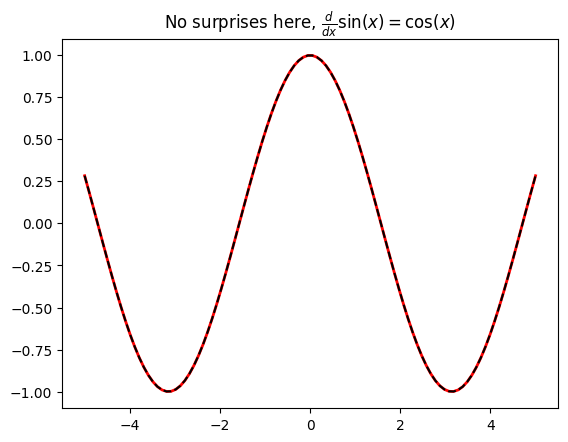

In [9]:
import matplotlib.pyplot as plt

def sin_func(x):
  return jnp.sin(x)

x = jnp.linspace(-5,5,100)

# Note we need to vmap our gradded function as jax.grad operates on scalar output functions only
grad_sin_func = jax.vmap(jax.grad(sin_func))
y = grad_sin_func(x)

plt.title(r'No surprises here, $\frac{d}{dx} \sin (x) = \cos (x)$')
plt.plot(x,y,'r',lw=2)
plt.plot(x,jnp.cos(x),'k--')
plt.show()

JAX also operates with what is known as "Pytrees", which are dictionaries of JAX arrays. This allows the naming of variables within a singular data structure which can make code easier to use as indexing is no longer required

See the following example:

In [16]:
def sin_variable_w_func(input):
  return jnp.sin(input['w']*input['x'])

# First for scalars
input = {'w' : 2.0, 'x' : 1.0}

scalar_grad_sin_variable_w_func = jax.grad(sin_variable_w_func)
scalar_grad_sin_variable_w_func(input)

{'w': Array(-0.41614684, dtype=float32, weak_type=True),
 'x': Array(-0.8322937, dtype=float32, weak_type=True)}

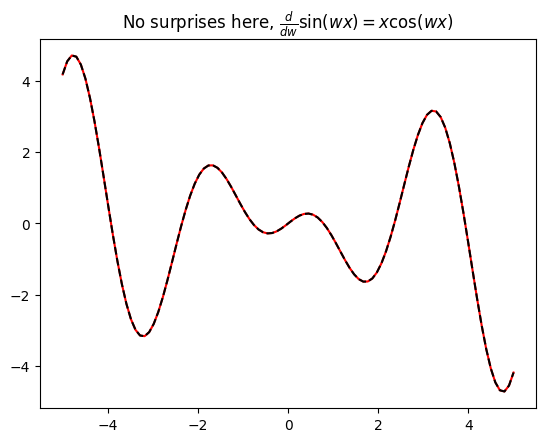

In [17]:
# Now for scalar w and vector x

input = {'w' : 2.0, 'x' : jnp.linspace(-5,5,100)}

vector_x_grad_sin_variable_w_func = jax.vmap(scalar_grad_sin_variable_w_func,
                                             in_axes=({'w' : None, 'x' : 0},))
out = vector_x_grad_sin_variable_w_func(input)

plt.title(r'No surprises here, $\frac{d}{dw} \sin (w x) = x \cos (w x)$')
plt.plot(x,out['w'],'r')
plt.plot(x,input['x']*jnp.cos(input['w']*input['x']),'k--')
plt.show()

## jax.jacfwd and jax.jacrev

We can also compute the gradients of functions with multi-dimensional outputs, in particular we can compute the Jacobian of function $f(x)$ where $x$ is n-dimensional and $f(x)$ returns an m-dimensional vector.

Mathematically, $J_f(x)$ is the Jacobian:

$$
  J_f(x) = \begin{bmatrix} \frac{d f_1}{dx_1} & \dots & \frac{d f_1}{dx_n} \\
  \vdots & & \vdots \\
  \frac{d f_m}{dx_1} & \dots & \frac{d f_m}{dx_n} \end{bmatrix}
$$

We can compute the Jacobian in forward- or reverse-mode automatic differentiation (jacfwd and jacrev respectively).

In [22]:
def sin_cos_func(x):
  """
  Test function with two outputs
  """
  return jnp.array([jnp.sum(jnp.sin(x)), jnp.sum(jnp.cos(x))])

x = jnp.linspace(-5,5,100)

forwardmode_jac = jax.jacfwd(sin_cos_func)
reversemode_jac = jax.jacrev(sin_cos_func)

forwardmode_out = forwardmode_jac(x)
reversemode_out = reversemode_jac(x)

print(f'The shape of the forward-mode Jacobian is {forwardmode_out.shape}')
print(f'The shape of the reverse-mode Jacobian is {reversemode_out.shape}')

assert jnp.isclose(forwardmode_out,reversemode_out).all()
# Note forwardmode_out =/= reversemode_out ! they involve different FLOPs

The shape of the forward-mode Jacobian is (2, 100)
The shape of the reverse-mode Jacobian is (2, 100)


We noted in the lecture that reverse-mode is more efficient for many-to-few functions, lets test this with our many-to-few test function

In [25]:
forwardmode_jac = jax.jit(forwardmode_jac)
reversemode_jac = jax.jit(reversemode_jac)

x_big = jnp.linspace(-5,5,1000)

forwardmode_time = timeit.timeit(lambda: forwardmode_jac(x_big), number=100)/100
reversemode_time = timeit.timeit(lambda: reversemode_jac(x_big), number=100)/100

print(f'Forward-mode time: {1e3*forwardmode_time:.4f} ms')
print(f'Reverse-mode time: {1e3*reversemode_time:.4f} ms')

Forward-mode time: 10.2967 ms
Reverse-mode time: 4.0549 ms


### **Advanced**: Jacobian-vector products (JVPs) and vector-Jacobian products (VJPs)

To really understand what is happening under the hood, we need to introduce JVPs and VJPs, which are related to forward- and reverse-mode AD respectively.

Let’s say you have a function that takes several inputs and returns several outputs. Think of this like a physical system where you tweak some parameters (the inputs) and observe some measurements (the outputs). The Jacobian of this function is like a giant matrix of sensitivities—how each output changes with each input.

But in practice, we don’t usually need the whole matrix when applying the chain rule.

Instead, we want to know what happens in a particular direction. That’s where Jacobian-vector products (JVPs) and vector-Jacobian products (VJPs) come in.

**Jacobian-Vector Product (JVP)**

This is used in forward-mode AD. It answers the question:

*“If I nudge my inputs a little bit in some direction, how do the outputs change?”*

Imagine you’re computing a function, $f(x)$, and you have some small perturbation $\delta x$. The JVP tells you how that perturbation propagates through the function:

$$
JVP =  J_f(x) \cdot \delta x
$$

You can think of the JVP like sending a small ripple through your system from the input side and seeing how it affects the output.

The JVP is efficient when the function, $f(x)$, is few-to-many (small number of inputs, large number of outputs).


In [ ]:
def test_function(x):
  res = {
      'f0' : (jnp.sin(x[1])+x[2]*jnp.sin(x[3]))*jnp.exp(x[0]),
      'f1' : (jnp.sin(x[1])+x[2]*jnp.sin(x[3]))*jnp.exp(-x[0])
  }
  return res

x = jnp.array([1.0,2.0,3.0,4.0])

# To get df/dx[i] for each i, we need to sweep through the JVP on the input space
for i in range(len(x)):
  v = jnp.eye(len(x))[i]
  y, u = jax.jvp(test_function, (x,), (v,))
  print(f'df/dx[{i}] = {u}')

df/dx[0] = {'f0': Array(-3.6998804, dtype=float32), 'f1': Array(0.5007244, dtype=float32)}
df/dx[1] = {'f0': Array(-1.1312044, dtype=float32), 'f1': Array(-0.15309188, dtype=float32)}
df/dx[2] = {'f0': Array(-2.0572023, dtype=float32), 'f1': Array(-0.27841207, dtype=float32)}
df/dx[3] = {'f0': Array(-5.3303623, dtype=float32), 'f1': Array(-0.72138613, dtype=float32)}


**Vector-Jacobian Product (VJP)**

This is used in reverse-mode AD. It answers the question:

*“How does a particular change in the outputs trace back to affect the inputs?”*

$$
VJP = \delta y^T \cdot J_f(x)
$$

This is like backpropagating a signal from the output side—asking how a change in a measurement pushes back through the system to influence the inputs. This is the basis for how gradients are computed efficiently when you have lots of inputs but only one output.

In [ ]:
y, vjp_fun = jax.vjp(test_function, x)

# To get df[j]/dx for each j, we need to sweep through the VJP on the output space
v = {'f0' : 1.0, 'f1' : 0.0}
u = vjp_fun(v)
print(f'df[0]/dx = {u}')

v = {'f0' : 0.0, 'f1' : 1.0}
u = vjp_fun(v)
print(f'df[1]/dx = {u}')

df[0]/dx = (Array([-3.6998804, -1.1312044, -2.0572023, -5.3303623], dtype=float32),)
df[1]/dx = (Array([ 0.5007244 , -0.15309188, -0.27841207, -0.7213862 ], dtype=float32),)


Note we get the same answer as with the JVP but with two calls to the VJP vs four calls to the VJP.

As a sanity check, here we compute the Jacobian using jacfwd and jacrev

In [ ]:
print(jax.jacfwd(test_function)(x))
print(jax.jacrev(test_function)(x))

{'f0': Array([-3.6998804, -1.1312044, -2.0572023, -5.3303623], dtype=float32), 'f1': Array([ 0.5007244 , -0.15309188, -0.27841207, -0.72138613], dtype=float32)}
{'f0': Array([-3.6998804, -1.1312044, -2.0572023, -5.3303623], dtype=float32), 'f1': Array([ 0.5007244 , -0.15309188, -0.27841207, -0.7213862 ], dtype=float32)}
